In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf

In [2]:
file = "/home/steam/Game_Reviews.csv"

# Pre-process reviews with Pandas

In [3]:
Game_Reviews = pd.read_csv(file, header = [0])

/opt/conda/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
Game_Reviews.head()

,id,recommendationid,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,steam_purchase,received_for_free,review,timestamp_updated,voted_up
0,920210,113388498,76561198021087473,1376,3,373,373,7,1649424182,True,False,So if you are like me and you want to play as ...,1649178978,True
1,920210,113442208,76561198065754924,417,69,726,726,287,1649525139,True,False,You can play as General Grievous\nYou can kill...,1649271143,True
2,920210,113390870,76561199122198186,43,3,277,277,10,1649451630,True,False,Yoda has a fat a** in this game can confirm.,1649182094,True
3,920210,113533400,76561198007644548,3170,60,706,706,359,1649515996,False,False,You can kill younglings!!!\n\nBest Game!\nGOTY...,1649437929,True
4,920210,113423698,76561198290950126,675,15,436,436,147,1649441082,False,False,this game is what i imagine sex is like,1649243606,True


In [5]:
review_vote = Game_Reviews[["num_games_owned", "num_reviews", "playtime_forever", "playtime_last_two_weeks", \
                            "playtime_at_review", "steam_purchase", "review","voted_up"]]

In [8]:
review_vote['num_games_owned'] = review_vote['num_games_owned'].astype(int)


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
review_vote['num_reviews'] = review_vote['num_reviews'].astype(int)


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
review_vote['playtime_forever'] = review_vote['playtime_forever'].astype(int)


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
review_vote['playtime_last_two_weeks'] = review_vote['playtime_last_two_weeks'].astype(int)


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
review_vote['playtime_at_review'] = review_vote['playtime_at_review'].apply(lambda x: str(x).replace("error", "0"))

review_vote['playtime_at_review'] = review_vote['playtime_at_review'].astype(int)


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
review_vote['steam_purchase'] = review_vote['steam_purchase'].apply(lambda x: 1 if x is True else 0)


/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
review_vote['review'] = review_vote['review'].astype(str)
review_vote['review'] = review_vote['review'].apply(lambda x: x.replace("\n", " "))

review_vote['vote'] = review_vote['voted_up'].apply(lambda x: 1 if x is True else 0)

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [21]:
# Remove the punctuations
import string
import re

remove_chars = '[·’!"\#$%&\'()＃！*+,-./:;<=>?\@，：?￥★、…．＞【】［］《》？“”‘’\[\\]^_`{|}~]+'

review_vote['review'] = review_vote['review'].apply(lambda x: re.sub(remove_chars, "", x))

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# review_vote = review_vote[["review","vote"]]
# review_vote

In [23]:
# Remove redundant spaces
review_vote["review"] = review_vote["review"].replace('\s+', ' ', regex=True)

/opt/conda/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
# drop na
review_vote = review_vote[review_vote["review"] != '']

In [27]:
len(review_vote)

11177283

In [26]:
# drop duplicate
review_vote = review_vote.drop_duplicates()

In [28]:
# save to a .csv file
review_data = review_vote.to_csv("/home/steam/cleaned_review.csv")

# Modeling with Pyspark

In [2]:
file2 = "hdfs://cluster-steam-m/user/dataproc/cleaned_review.csv"

In [3]:
df = pd.read_csv("/home/steam/cleaned_review.csv")
df.head()

,Unnamed: 0,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,steam_purchase,review,voted_up,vote
0,0,1376,3,373,373,7,1,So if you are like me and you want to play as ...,True,1
1,1,417,69,726,726,287,1,You can play as General Grievous You can kill ...,True,1
2,2,43,3,277,277,10,1,Yoda has a fat a in this game can confirm,True,1
3,3,3170,60,706,706,359,0,You can kill younglings Best Game GOTY 1010,True,1
4,4,675,15,436,436,147,0,this game is what i imagine sex is like,True,1


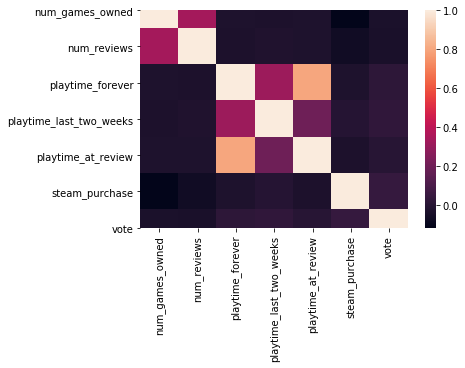

In [8]:
eda_df = df[['num_games_owned', 'num_reviews', 'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review', 'steam_purchase', 'vote']]
eda_df = eda_df.dropna()

import seaborn as sns
cormat = eda_df.corr()
# cormat = round(cormat,2)
sns.heatmap(cormat);

In [4]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import NGram
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [5]:
import os
import pandas as pd
from pyspark.sql import SparkSession
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

spark = SparkSession.builder.master("local[8]").appName("DataFrame").getOrCreate()

In [6]:
review_info = spark.read.csv(file2, inferSchema = True, header =True)

In [7]:
review_info = review_info.dropna()

In [8]:
tokenizer = Tokenizer(inputCol="review", outputCol="words")
wordsData = tokenizer.transform(review_info)
wordsData.show(5, truncate=False)

+---+---------------+-----------+----------------+-----------------------+------------------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filtData = remover.transform(wordsData)
filtData.show(5, truncate=False)


+---+---------------+-----------+----------------+-----------------------+------------------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
ngram = NGram(n=2, inputCol="filtered", outputCol="ngrams")
ngramData = ngram.transform(filtData)
ngramData.select("ngrams").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
hashingTF = HashingTF(inputCol="ngrams", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(ngramData)
featurizedData.show(5, truncate=False)

+---+---------------+-----------+----------------+-----------------------+------------------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
idf = IDF(inputCol="rawFeatures", outputCol="review_features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.show(5, truncate=False)

+---+---------------+-----------+----------------+-----------------------+------------------+--------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
rescaledData = rescaledData.withColumnRenamed("vote", "label").filter(size("words") > 1)

In [14]:
rescaledData.show(5)

+---+---------------+-----------+----------------+-----------------------+------------------+--------------+--------------------+--------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|_c0|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|steam_purchase|              review|voted_up|label|               words|            filtered|              ngrams|         rawFeatures|     review_features|
+---+---------------+-----------+----------------+-----------------------+------------------+--------------+--------------------+--------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|  0|           1376|          3|             373|                    373|                 7|             1|So if you are lik...|    true|    1|[so, if, you, are...|[like, want, play...|[like want, want ...|(20,[0,1,2,3,4,5,...|(20,[0,1,2,3,4,5,...|


In [15]:
reviews_after_proc = rescaledData.select("num_games_owned", "num_reviews", "playtime_forever", "playtime_last_two_weeks",\
                                         "playtime_at_review", "steam_purchase", "review_features", "label")

In [16]:
from pyspark.sql.types import IntegerType

reviews_after_proc = reviews_after_proc.\
        withColumn("num_games_owned", reviews_after_proc["num_games_owned"].cast(IntegerType())).\
        withColumn("num_reviews", reviews_after_proc["num_reviews"].cast(IntegerType())).\
        withColumn("playtime_forever", reviews_after_proc["playtime_forever"].cast(IntegerType())).\
        withColumn("playtime_last_two_weeks", reviews_after_proc["playtime_last_two_weeks"].cast(IntegerType())).\
        withColumn("playtime_at_review", reviews_after_proc["playtime_at_review"].cast(IntegerType())).\
        withColumn("steam_purchase", reviews_after_proc["steam_purchase"].cast(IntegerType()))
reviews_after_proc.show(5)

+---------------+-----------+----------------+-----------------------+------------------+--------------+--------------------+-----+
|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|steam_purchase|     review_features|label|
+---------------+-----------+----------------+-----------------------+------------------+--------------+--------------------+-----+
|           1376|          3|             373|                    373|                 7|             1|(20,[0,1,2,3,4,5,...|    1|
|            417|         69|             726|                    726|               287|             1|(20,[0,1,2,3,4,7,...|    1|
|             43|          3|             277|                    277|                10|             1|(20,[3,4,12],[0.8...|    1|
|           3170|         60|             706|                    706|               359|             0|(20,[1,12,13,16,1...|    1|
|            675|         15|             436|                    436|      

In [17]:
assembler = VectorAssembler(inputCols=["num_games_owned", "num_reviews", "playtime_forever", "playtime_last_two_weeks",\
                                         "playtime_at_review", "steam_purchase"], outputCol="numeric_features")
numeric_output = assembler.transform(reviews_after_proc)
numeric_output.show(truncate=False)

+---------------+-----------+----------------+-----------------------+------------------+--------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-------------------------------------+
|num_games_owned|num_reviews|playtime_forever|playtime_last_two_weeks|playtime_at_review|steam_purchase|review_features                                                                                                                                                                                                                                                                                                              

In [18]:
assembler = VectorAssembler(inputCols=["numeric_features", "review_features"], outputCol="features")
final_output = assembler.transform(numeric_output).select("features", 'label')
final_output.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                                                                                |label|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
# split dataset into 0.8/0.1.0.1 (train/val/test)
train_set, val_set, test_set = final_output.randomSplit([0.001, 0.001, 0.998], seed = 336)

## LR

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(maxIter=10)
lrModel = lr.fit(train_set)

In [101]:
lr_predictions = lrModel.transform(val_set)
lr_predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(26,[0,1,2,3,4],[...|    0|[-1.5858136675666...|[0.16997370003797...|       1.0|
|(26,[0,1,2,3,4,5]...|    1|[-2.3765529713480...|[0.08497821288994...|       1.0|
|(26,[0,1,2,3,4,5]...|    1|[-1.7936068076670...|[0.14263108735782...|       1.0|
|(26,[0,1,2,3,4,5]...|    1|[-2.1150834002890...|[0.10763941527076...|       1.0|
|(26,[0,1,2,3,4,5]...|    1|[-1.8039744162546...|[0.14136795014917...|       1.0|
|(26,[0,1,2,3,4,5]...|    1|[-1.8065875941885...|[0.14105105180175...|       1.0|
|(26,[0,1,2,3,4,5,...|    0|[-1.8148338464711...|[0.14005492588617...|       1.0|
|(26,[0,1,2,3,4,5,...|    1|[-2.2225243486107...|[0.09774595157845...|       1.0|
|(26,[0,1,2,3,4,5,...|    1|[-1.6318548141674...|[0.16357642868676...|       1.0|
|(26,[0,1,2,3,4,

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.642126551752747

In [ ]:
mcevaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
lr_accuracy = mcevaluator.evaluate(lr_predictions)
print("f1 = %g " % lr_accuracy)

f1 = 0.761415 


## DT

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
dtmodel = dt.fit(train_set)
dt_predictions = dtmodel.transform(val_set)

mcevaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
dt_accuracy = mcevaluator.evaluate(dt_predictions)
print("f1 = %g " % dt_accuracy)

f1 = 0.798941 


In [26]:
dtmodel.featuresCol

Param(parent='DecisionTreeClassifier_4647211c0b3e', name='featuresCol', doc='features column name')

In [23]:
dtmodel.featureImportances

SparseVector(26, {0: 0.0168, 1: 0.0333, 2: 0.5623, 4: 0.0428, 5: 0.0129, 8: 0.0346, 16: 0.073, 17: 0.0129, 19: 0.0249, 20: 0.0068, 21: 0.143, 23: 0.0063, 24: 0.015, 25: 0.0153})

In [21]:
mcevaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

for i in [7,8]:
  new_dt = dt.setMaxDepth(i)
  new_model = new_dt.fit(train_set)
  new_predictions = new_model.transform(val_set)
  new_accuracy = mcevaluator.evaluate(new_predictions)
  print("max depth = %d, accuracy = %g, number of nodes = %d" % (i, new_accuracy, new_model.numNodes))

max depth = 7, accuracy = 0.793909, number of nodes = 183
max depth = 8, accuracy = 0.794183, number of nodes = 293


In [ ]:

for i in [9,12]:
  new_dt = dt.setMaxDepth(i)
  new_model = new_dt.fit(train_set)
  new_predictions = new_model.transform(val_set)
  new_accuracy = mcevaluator.evaluate(new_predictions)
  print("max depth = %d, accuracy = %g, number of nodes = %d" % (i, new_accuracy, new_model.numNodes))

max depth = 9, accuracy = 0.789608, number of nodes = 459
max depth = 12, accuracy = 0.780288, number of nodes = 1029


## RF

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfmodel = rf.fit(train_set)
rf_predictions = rfmodel.transform(val_set)

mcevaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
rf_accuracy = mcevaluator.evaluate(rf_predictions)
print("f1 = %g " % rf_accuracy)

f1 = 0.785092 


## GBT

In [ ]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbtmodel = gbt.fit(train_set)
gbt_predictions = gbtmodel.transform(val_set)

mcevaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
gbt_accuracy = mcevaluator.evaluate(gbt_predictions)
print("f1 = %g " % gbt_accuracy)

f1 = 0.797656 


In [109]:
print("A")

A
